In [9]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_ci, classical_ols_ci
from statsmodels.regression.linear_model import OLS
from tqdm import tqdm
from utils import *

# Import the census income data set

In [4]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

# Problem setup

In [10]:
alpha = 0.05
coordinate = 0 # Choose between 0, 1
n_total = Y.shape[0]  # Total number of labeled examples
ns = np.linspace(100, 2000, 10).astype(
    int
)  # Test for different numbers of labeled ballots
num_trials = 50
# Compute ground truth
true_theta = OLS(Y_total, exog=X_total).fit().params[coordinate]

# Construct intervals

In [12]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y[rand_idx[:n]], Y[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = Yhat[rand_idx[:n]], Yhat[rand_idx[n:]]
        
        ppi_ci = ppi_ols_ci(_X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha)

        # Classical interval
        classical_ci = classical_ols_ci(_X, _Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0][coordinate],
                        "upper": ppi_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0][coordinate],
                        "upper": classical_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_ols_ci(X_total, Yhat_total, alpha=alpha)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0][coordinate],
                "upper": imputed_ci[1][coordinate],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.85s/it]


# Plot results

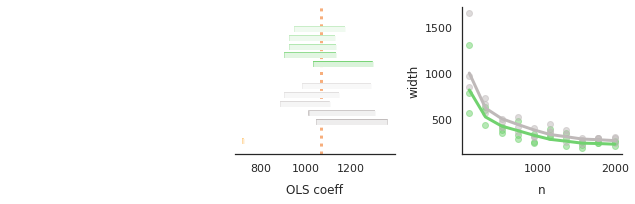

In [14]:
make_plots(
    df,
    "./plots/census_income.pdf",
    intervals_xlabel="OLS coeff",
    true_theta=true_theta,
)